## Evaluating LLM performance under different loads

You have two options here:
1. Evaluate it end-to-end
2. using a pre-generated results to evaluate

#### End-to-end Evaluation
Evaluating using `eval_mmlu.py` to run the full evaluation. We now only support testing with `text-generation-inference`. Make sure you set the model type to `tgi`, set `stream: true` under `args` section in model configuration and set it with correct backend URL.
You will get the booting time and completion time along in the `.jsonl` file, which is a list of `QAPrediction` dumps.

Here's an example:
```yaml
model:
    type: "tgi"
    args:
        name: "llama2-13b-chat-hf"
        backend_url: "your-tgi-backend-url"
        system_prompt: ""
        stream: true
        record_template: "[INST]The following are multiple choice questions (with answers) with context:\n\n{context}Question: {question}\n{choices}[/INST]Answer: "
    run_args:
        max_new_tokens: 100
        stop_sequences: 
            - ".\n\n"
```

#### Pre-generated Evaluation
Sometimes you may not want to retrieve the context everytime you evaluate the LLM. You can use `.jsonl` as inputs to get those results.
You can write your own scripts to organize the data. 

**Notably**, stream enabled TGI generations only have **word count** on prompt tokens. You need to run it with non-stream mode to obtain the concert numbers of prompt tokens.

=========

Happy experimenting and have fun with it! 😊

In [1]:
import json
from glob import glob
from matplotlib import pyplot as plt

parallel_d = {}
threads = ['1', '4', '8', '16', '32', '64']
for t in threads:
    j = []
    files = glob(f'*.t{t}.jsonl')
    for fn in files:
        with open(fn) as f:
            j.append([json.loads(l) for l in f.readlines()])
    if t not in parallel_d:
        parallel_d[t] = []
    parallel_d[t] = j


/var/folders/f9/bcrnh8c13g98t4x7v5jgph7w0000gp/T/ipykernel_66890/2145290746.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


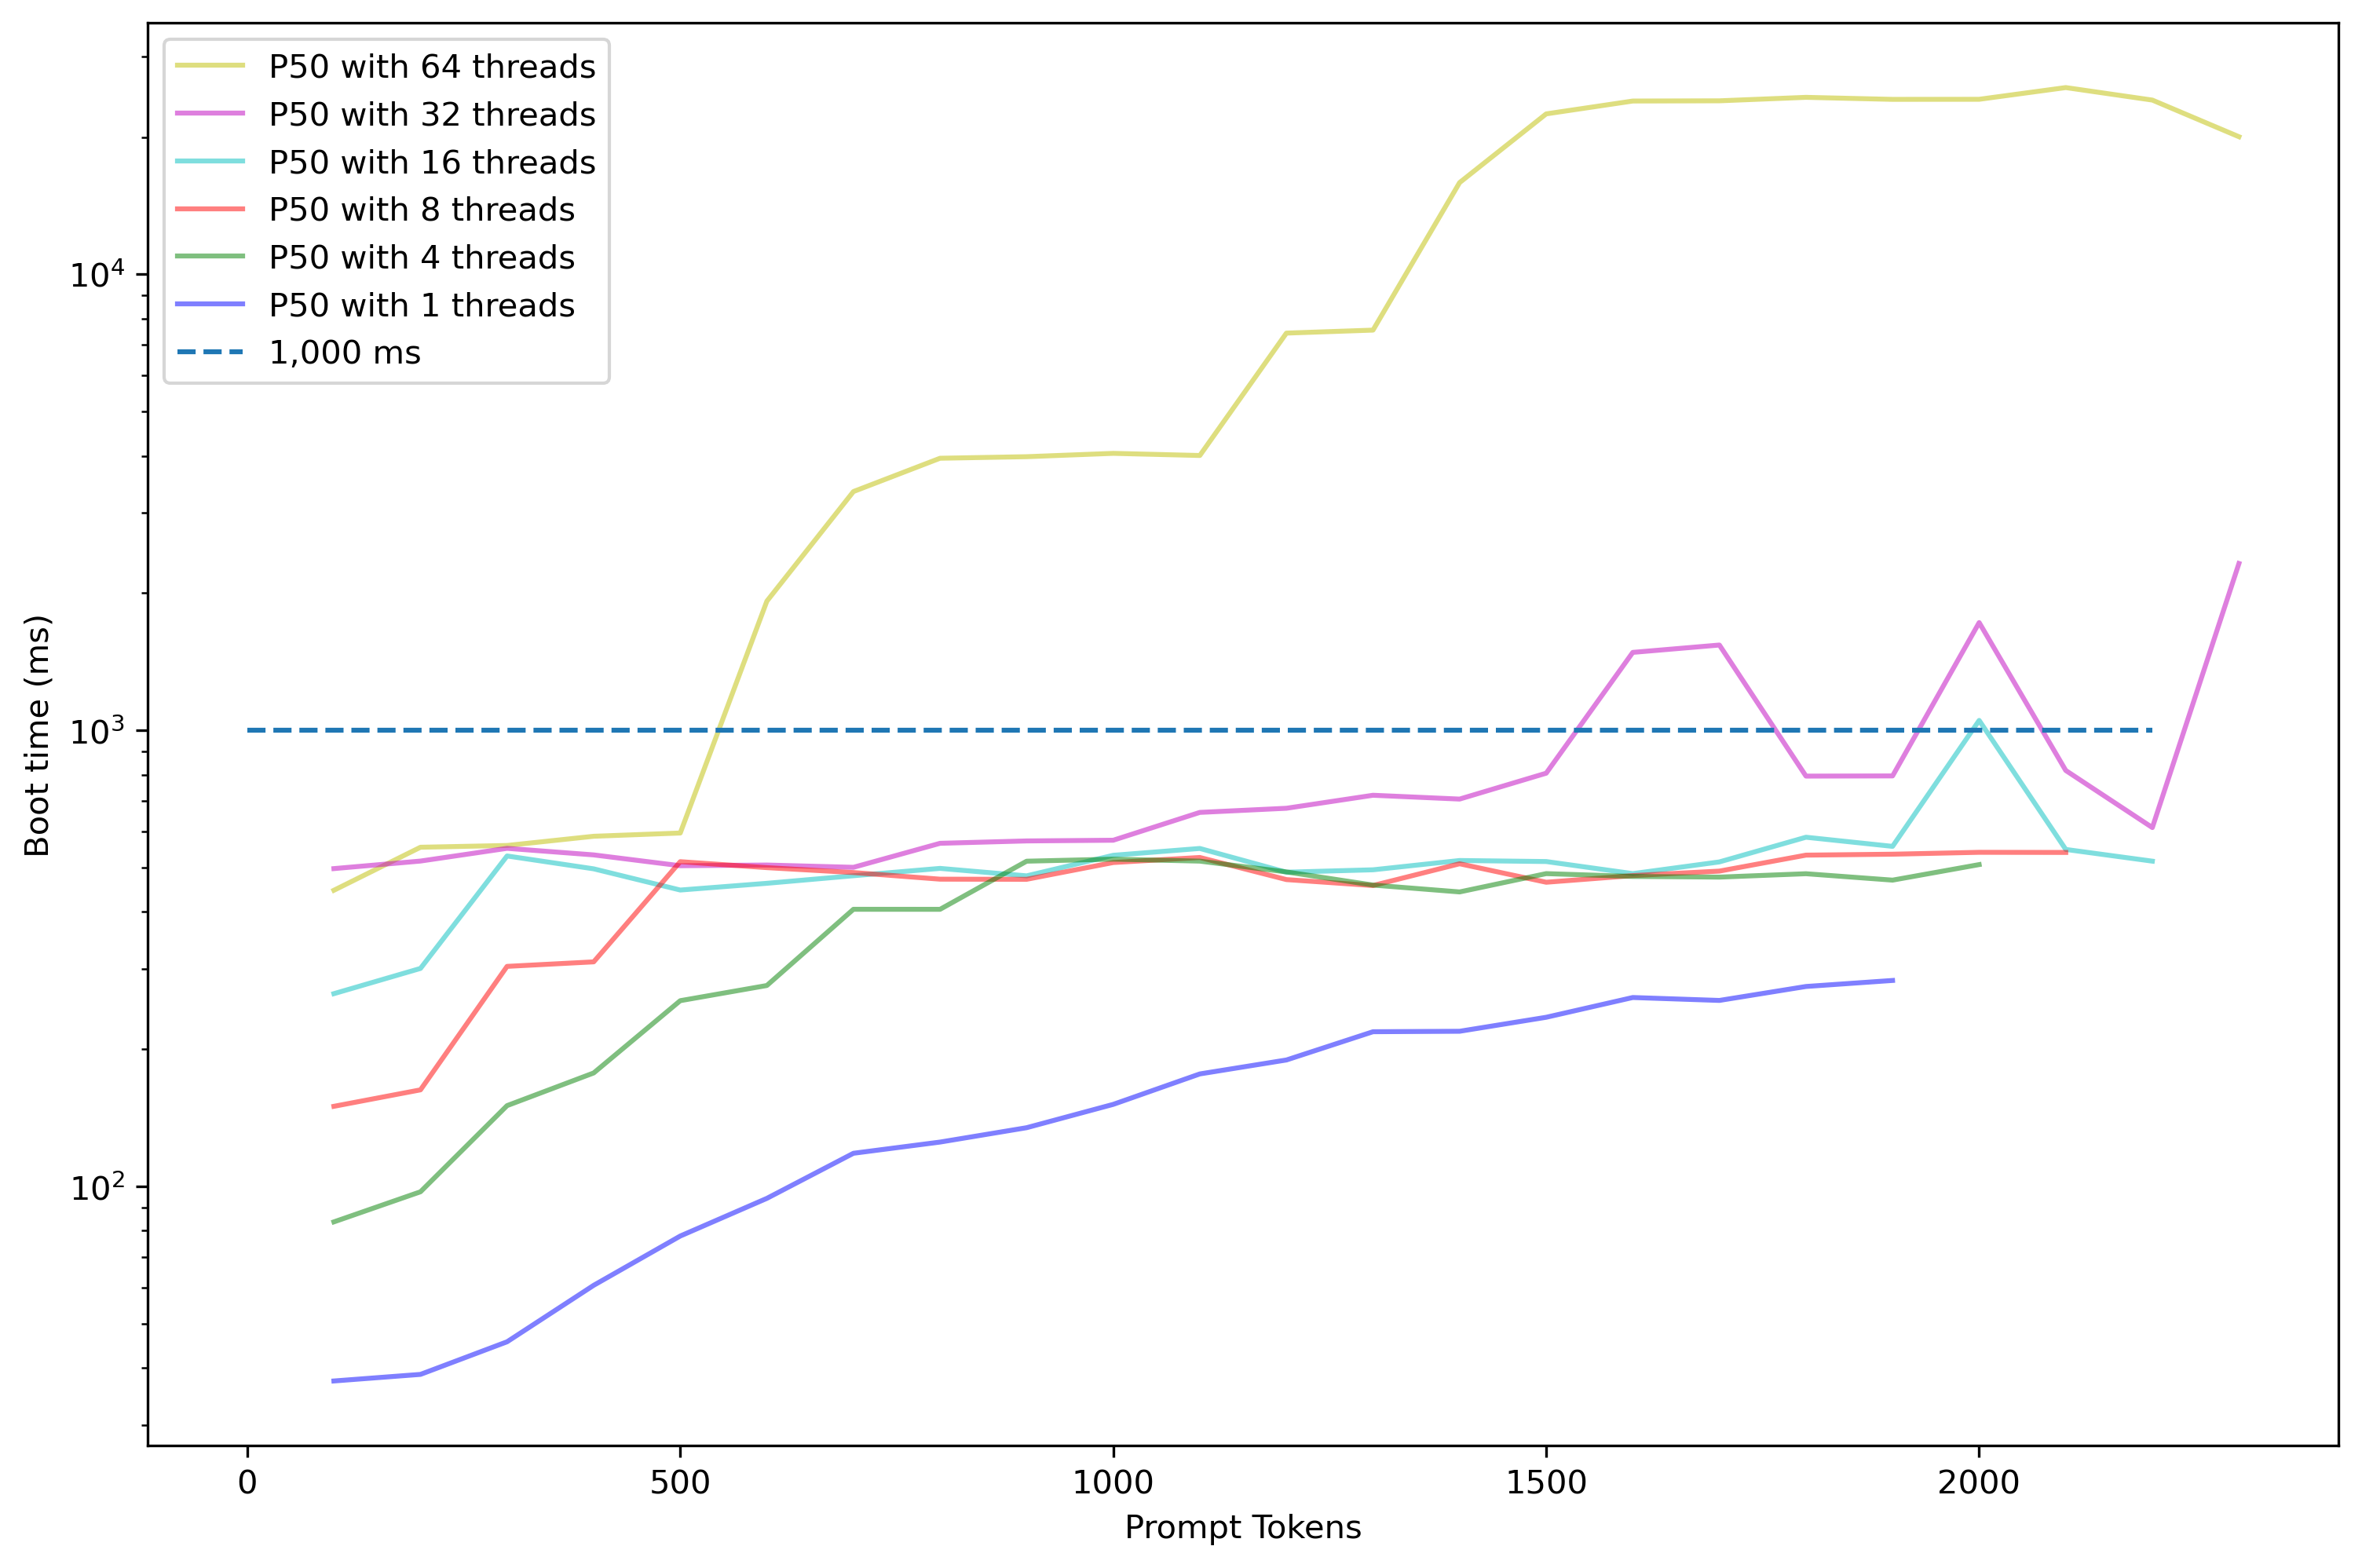

In [42]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

key = "boot_time"

colors = ["b", "g", "r", "c", "m", "y"][::-1]
step_size = 100

for i, (k, v) in enumerate(list(parallel_d.items())[::-1]):
    if True:
        x, y, c = list(
            zip(
                *[
                    (
                        d["prompt_tokens"],
                        d["profile_avg"]["model.tgi.boot.profile"],
                        d["completion_tokens"],
                    )
                    for d in v
                ]
            )
        )
        sx, sy = list(map(np.array, [x, y]))
        _, sind = np.unique(sx, return_index=True)
        _x = []
        _y = []
        for _c in range(100, sx.max(), step_size):
            _ind = np.logical_and(sx < _c, sx >= (_c - step_size))
            if sy[_ind].shape[0] > 0:
                _x.append(_c)
                _y.append([np.percentile(sy[_ind], p) for p in [5, 25, 50, 75, 95]])

        # ax.fill_between(_x, [__y[0] for __y in _y], [__y[4] for __y in _y],
        #                 color=colors[i], label=f'number of threads: {k}', alpha=0.3)
        # for l, (l1, l2) in enumerate([(0, 4), (1, 3)]):
        #     ax.fill_between(_x, [__y[l1] for __y in _y], [__y[l2] for __y in _y],
        #                     color=colors[i], alpha=0.05 * (l+1))
        ax.plot(
            _x,
            [__y[2] for __y in _y],
            color=colors[i],
            label=f"P50 with {k} threads",
            alpha=0.5,
        )
ax.hlines(1000, 0, 2200, linestyles="dashed", label="1,000 ms")
ax.set_yscale("log")
ax.set_ylabel("Boot time (ms)")
ax.set_xlabel("Prompt Tokens")
ax.title("")
ax.legend()
fig.show()
fig.savefig("booting-time.png")

/var/folders/f9/bcrnh8c13g98t4x7v5jgph7w0000gp/T/ipykernel_66890/1148215930.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


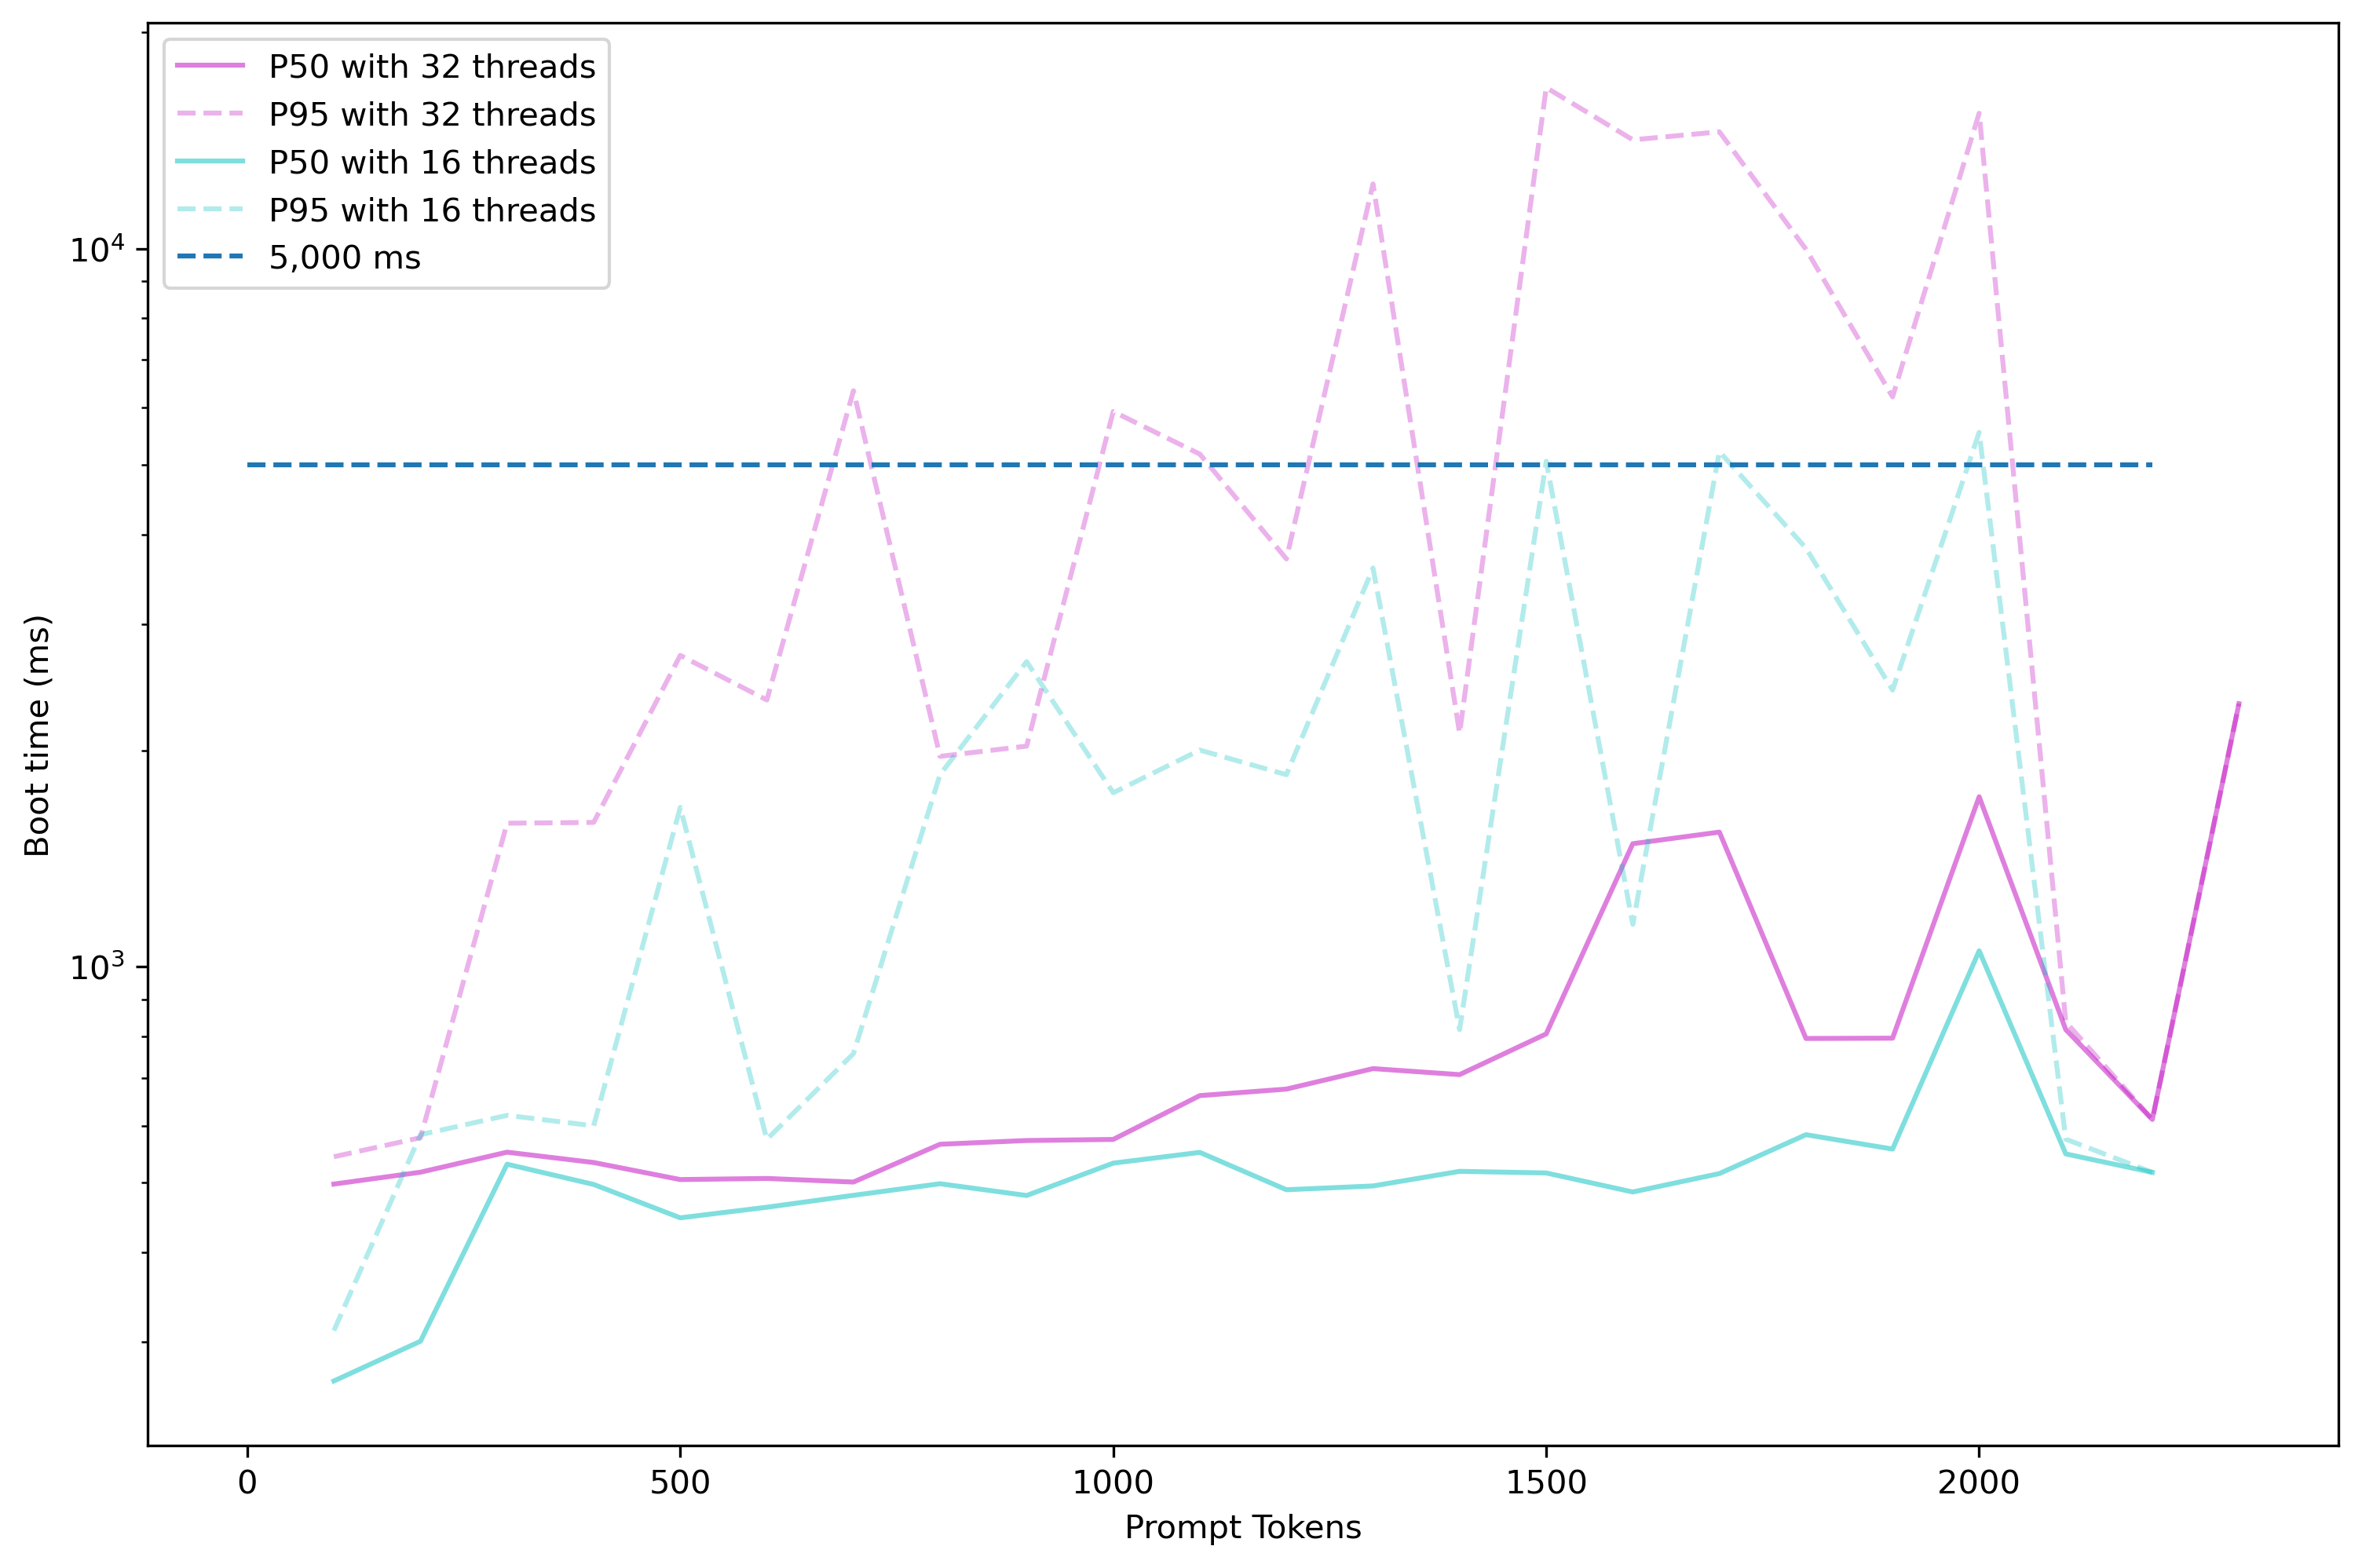

In [41]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

key = "boot_time"

colors = ["b", "g", "r", "c", "m", "y"][::-1]
step_size = 100

for i, (k, v) in enumerate(list(parallel_d.items())[::-1]):
    if k in ["16", "32"]:
        x, y, c = list(
            zip(
                *[
                    (
                        d["prompt_tokens"],
                        d["profile_avg"]["model.tgi.boot.profile"],
                        d["completion_tokens"],
                    )
                    for d in v
                ]
            )
        )
        sx, sy = list(map(np.array, [x, y]))
        _, sind = np.unique(sx, return_index=True)
        _x = []
        _y = []
        for _c in range(100, sx.max(), step_size):
            _ind = np.logical_and(sx < _c, sx >= (_c - step_size))
            if sy[_ind].shape[0] > 0:
                _x.append(_c)
                _y.append([np.percentile(sy[_ind], p) for p in [5, 25, 50, 75, 95]])

        # ax.fill_between(_x, [__y[0] for __y in _y], [__y[4] for __y in _y],
        #                 color=colors[i], label=f'number of threads: {k}', alpha=0.3)
        # for l, (l1, l2) in enumerate([(0, 4), (1, 3)]):
        #     ax.fill_between(_x, [__y[l1] for __y in _y], [__y[l2] for __y in _y],
        #                     color=colors[i], alpha=0.05 * (l+1))
        ax.plot(
            _x,
            [__y[2] for __y in _y],
            color=colors[i],
            label=f"P50 with {k} threads",
            alpha=0.5,
        )
        ax.plot(
            _x,
            [__y[-1] for __y in _y],
            "--",
            color=colors[i],
            label=f"P95 with {k} threads",
            alpha=0.3,
        )
ax.hlines(5000, 0, 2200, linestyles="dashed", label="5,000 ms")
ax.set_yscale("log")
ax.set_ylabel("Boot time (ms)")
ax.set_xlabel("Prompt Tokens")
ax.legend()
fig.show()
fig.savefig("booting-time-p95.png")

/var/folders/f9/bcrnh8c13g98t4x7v5jgph7w0000gp/T/ipykernel_66890/1235182846.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


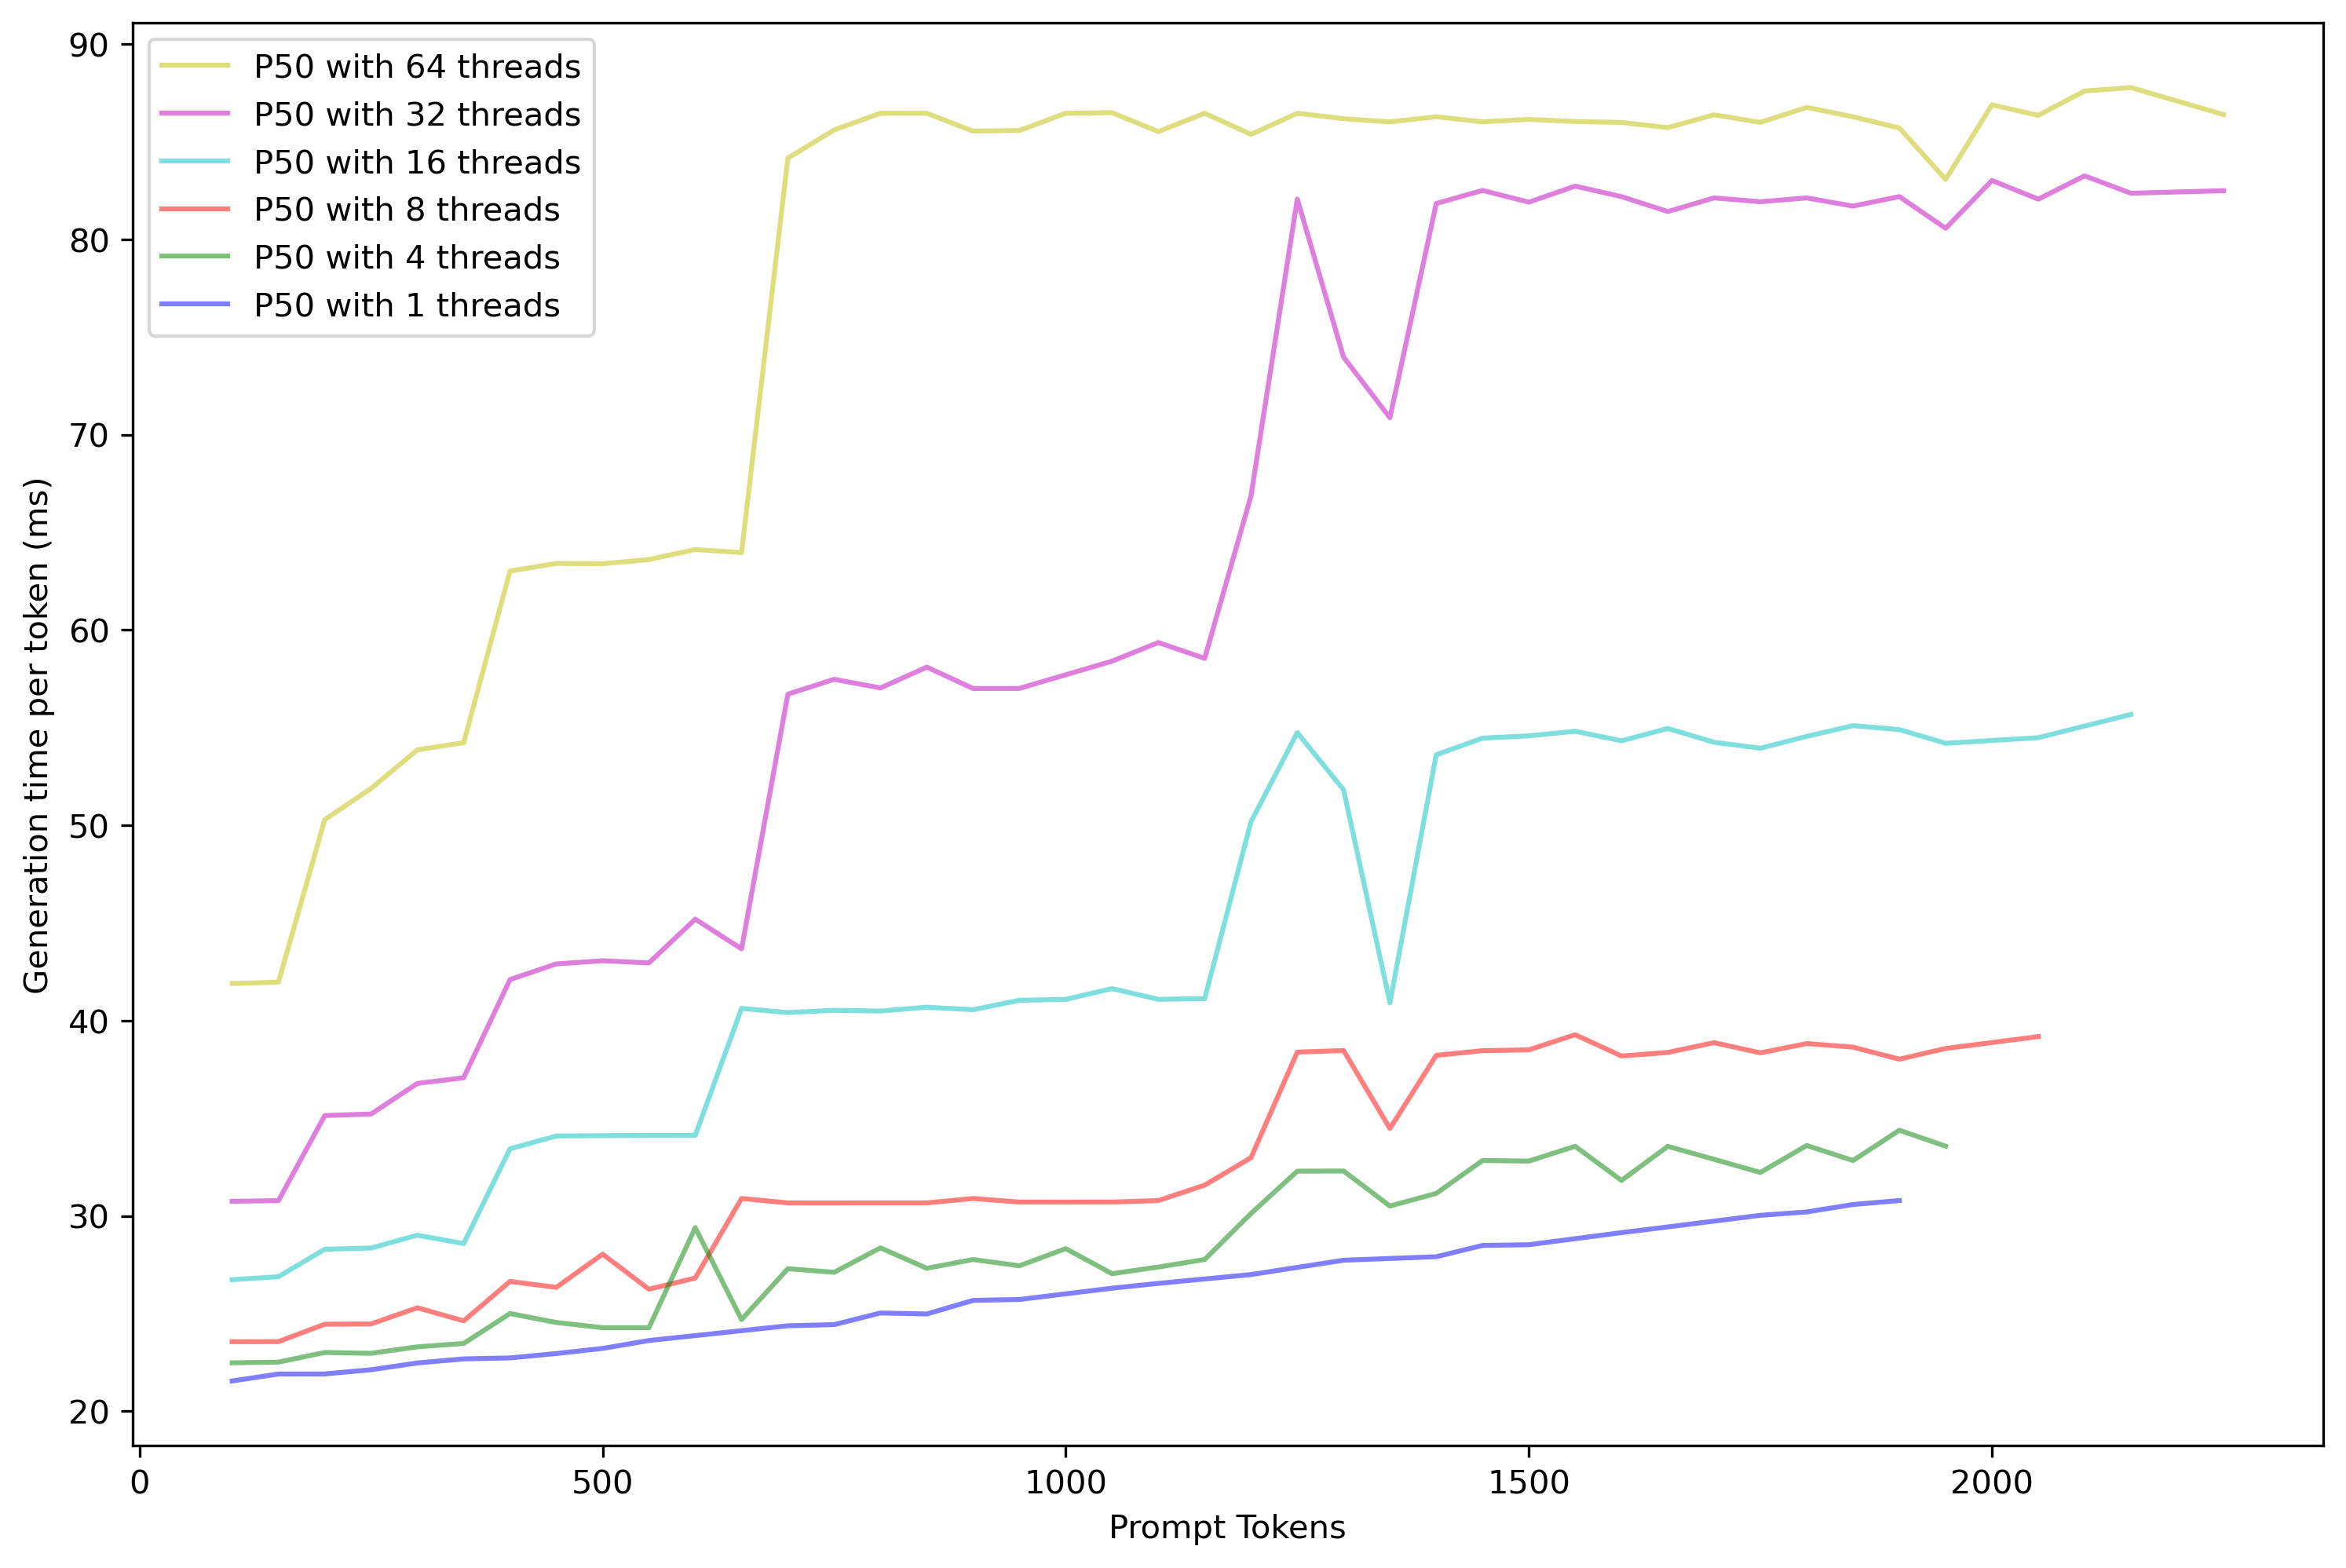

In [34]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

key = "boot_time"

colors = ["b", "g", "r", "c", "m", "y"][::-1]

step_size = 50

for i, (k, v) in enumerate(list(parallel_d.items())[::-1]):
    if True:
        x, y, c = list(
            zip(
                *[
                    (
                        d["prompt_tokens"],
                        (d["profile_avg"]["model.tgi.completion.profile"]),
                        d["completion_tokens"],
                    )
                    for d in v
                ]
            )
        )
        sx, sy = list(map(np.array, [x, y]))
        _, sind = np.unique(sx, return_index=True)
        xnew = np.linspace(sx.min(), sx.max(), 1000)

        _x = []
        _y = []
        for _c in range(100, sx.max(), step_size):
            _ind = np.logical_and(sx < _c, sx >= (_c - step_size))
            if sy[_ind].shape[0] > 0:
                _x.append(_c)
                _y.append([np.percentile(sy[_ind], p) for p in [5, 25, 50, 75, 95]])

        # ax.fill_between(_x, [__y[0] for __y in _y], [__y[4] for __y in _y],
        #                 color=colors[i], label=f'number of threads: {k}', alpha=0.3)
        # for l, (l1, l2) in enumerate([(0, 4), (1, 3)]):
        #     ax.fill_between(_x, [__y[l1] for __y in _y], [__y[l2] for __y in _y],
        #                     color=colors[i], alpha=0.05 * (l+1))
        ax.plot(
            _x,
            [__y[2] for __y in _y],
            color=colors[i],
            label=f"P50 with {k} threads",
            alpha=0.5,
        )
ax.set_ylabel("Generation time per token (ms)")
ax.set_xlabel("Prompt Tokens")
ax.legend()
fig.show()
fig.savefig("generation-latency.png")

/var/folders/f9/bcrnh8c13g98t4x7v5jgph7w0000gp/T/ipykernel_66890/2166379016.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


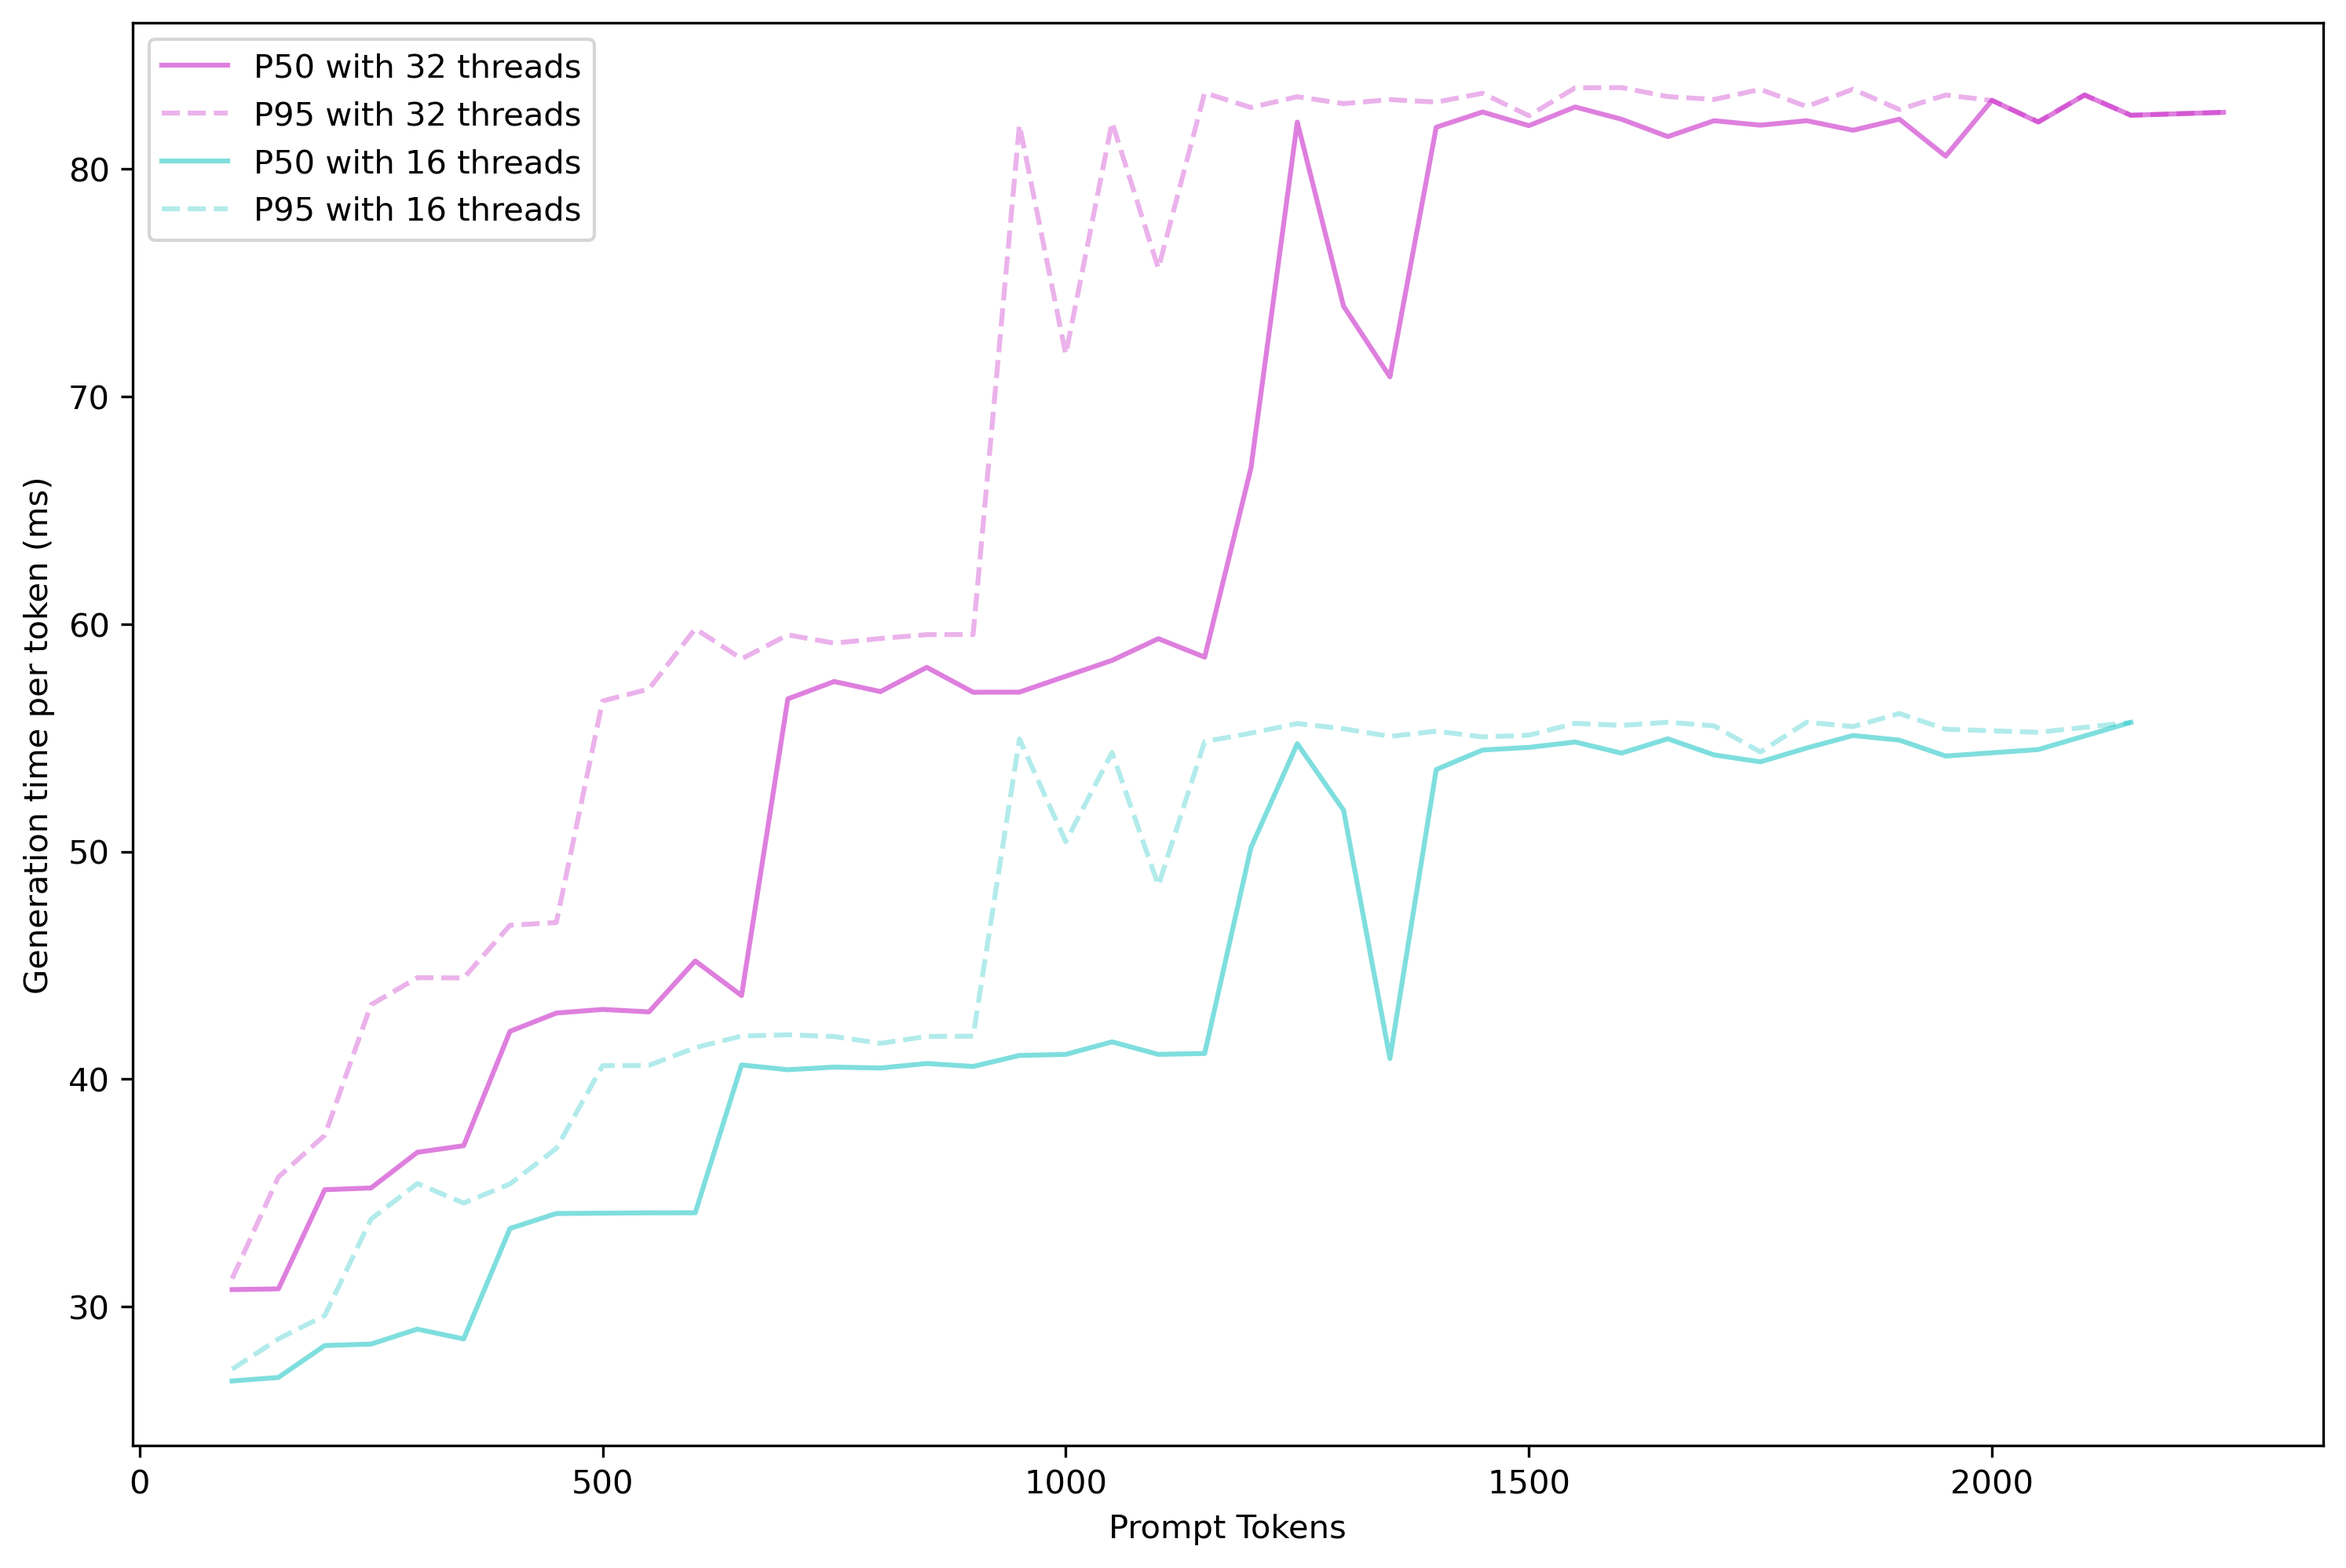

In [43]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

key = "boot_time"

colors = ["b", "g", "r", "c", "m", "y"][::-1]

step_size = 50

for i, (k, v) in enumerate(list(parallel_d.items())[::-1]):
    if k in ["16", "32"]:
        x, y, c = list(
            zip(
                *[
                    (
                        d["prompt_tokens"],
                        (d["profile_avg"]["model.tgi.completion.profile"]),
                        d["completion_tokens"],
                    )
                    for d in v
                ]
            )
        )
        sx, sy = list(map(np.array, [x, y]))
        _, sind = np.unique(sx, return_index=True)
        xnew = np.linspace(sx.min(), sx.max(), 1000)

        _x = []
        _y = []
        for _c in range(100, sx.max(), step_size):
            _ind = np.logical_and(sx < _c, sx >= (_c - step_size))
            if sy[_ind].shape[0] > 0:
                _x.append(_c)
                _y.append([np.percentile(sy[_ind], p) for p in [5, 25, 50, 75, 95]])

        # ax.fill_between(_x, [__y[0] for __y in _y], [__y[4] for __y in _y],
        #                 color=colors[i], label=f'number of threads: {k}', alpha=0.3)
        # for l, (l1, l2) in enumerate([(0, 4), (1, 3)]):
        #     ax.fill_between(_x, [__y[l1] for __y in _y], [__y[l2] for __y in _y],
        #                     color=colors[i], alpha=0.05 * (l+1))
        ax.plot(
            _x,
            [__y[2] for __y in _y],
            color=colors[i],
            label=f"P50 with {k} threads",
            alpha=0.5,
        )
        ax.plot(
            _x,
            [__y[-1] for __y in _y],
            "--",
            color=colors[i],
            label=f"P95 with {k} threads",
            alpha=0.3,
        )
ax.set_ylabel("Generation time per token (ms)")
ax.set_xlabel("Prompt Tokens")
ax.legend()
fig.show()
fig.savefig("generation-latency-p95.png")

/var/folders/f9/bcrnh8c13g98t4x7v5jgph7w0000gp/T/ipykernel_66890/3056162885.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


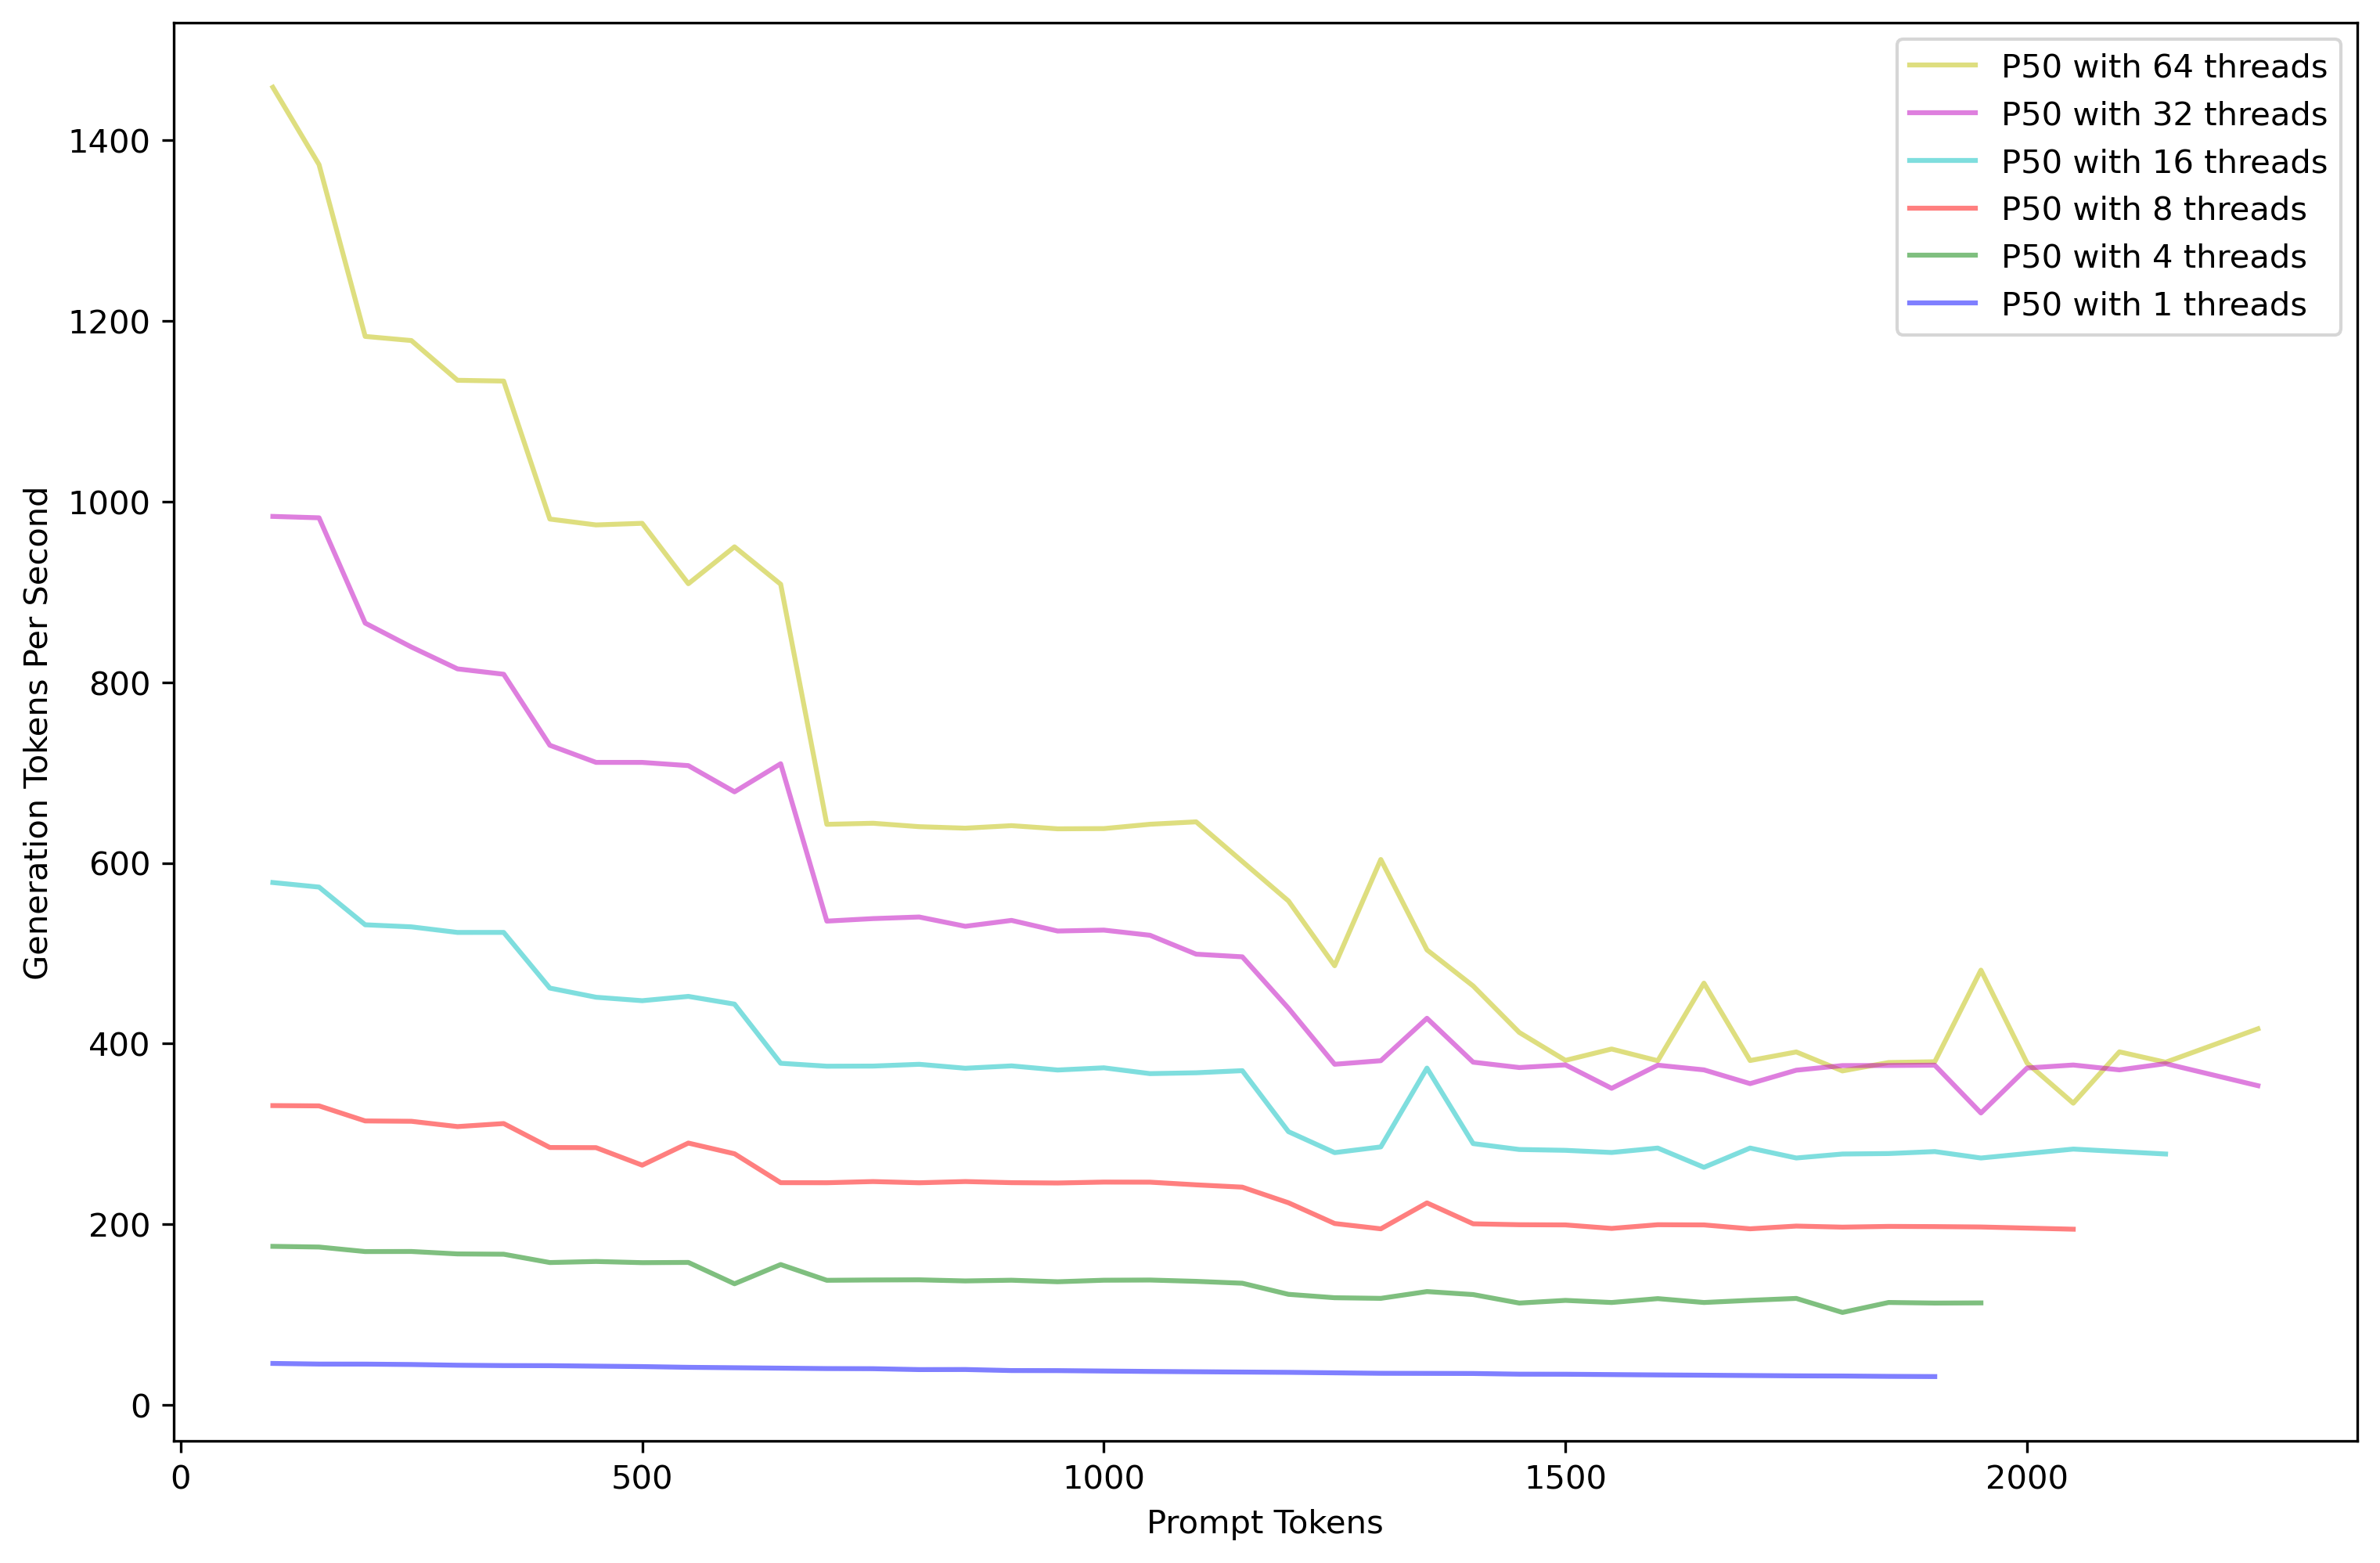

In [30]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

key = "boot_time"

colors = ["b", "g", "r", "c", "m", "y"][::-1]

step_size = 50

for i, (k, v) in enumerate(list(parallel_d.items())[::-1]):
    if True or k != "64":
        x, y, c = list(
            zip(
                *[
                    (
                        d["prompt_tokens"],
                        int(k)
                        * 1000
                        / (
                            (
                                d["profile_time"]["model.tgi.boot.profile"]
                                + d["profile_time"]["model.tgi.completion.profile"]
                            )
                            / d["completion_tokens"]
                        ),
                        d["completion_tokens"],
                    )
                    for d in v
                ]
            )
        )
        sx, sy = list(map(np.array, [x, y]))
        _, sind = np.unique(sx, return_index=True)
        xnew = np.linspace(sx.min(), sx.max(), 1000)

        _x = []
        _y = []
        for _c in range(100, sx.max(), step_size):
            _ind = np.logical_and(sx < _c, sx >= (_c - step_size))
            if sy[_ind].shape[0] > 0:
                _x.append(_c)
                _y.append([np.percentile(sy[_ind], p) for p in [5, 25, 50, 75, 95]])

        # ax.fill_between(_x, [__y[0] for __y in _y], [__y[4] for __y in _y],
        #                 color=colors[i], label=f'number of threads: {k}', alpha=0.3)
        # for l, (l1, l2) in enumerate([(0, 4), (1, 3)]):
        #     ax.fill_between(_x, [__y[l1] for __y in _y], [__y[l2] for __y in _y],
        #                     color=colors[i], alpha=0.05 * (l+1))
        ax.plot(
            _x,
            [__y[2] for __y in _y],
            color=colors[i],
            label=f"P50 with {k} threads",
            alpha=0.5,
        )
ax.set_ylabel("Generation Tokens Per Second")
ax.set_xlabel("Prompt Tokens")
ax.legend()
fig.show()
fig.savefig("generation-throughput.png")

/var/folders/f9/bcrnh8c13g98t4x7v5jgph7w0000gp/T/ipykernel_66890/2333602239.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


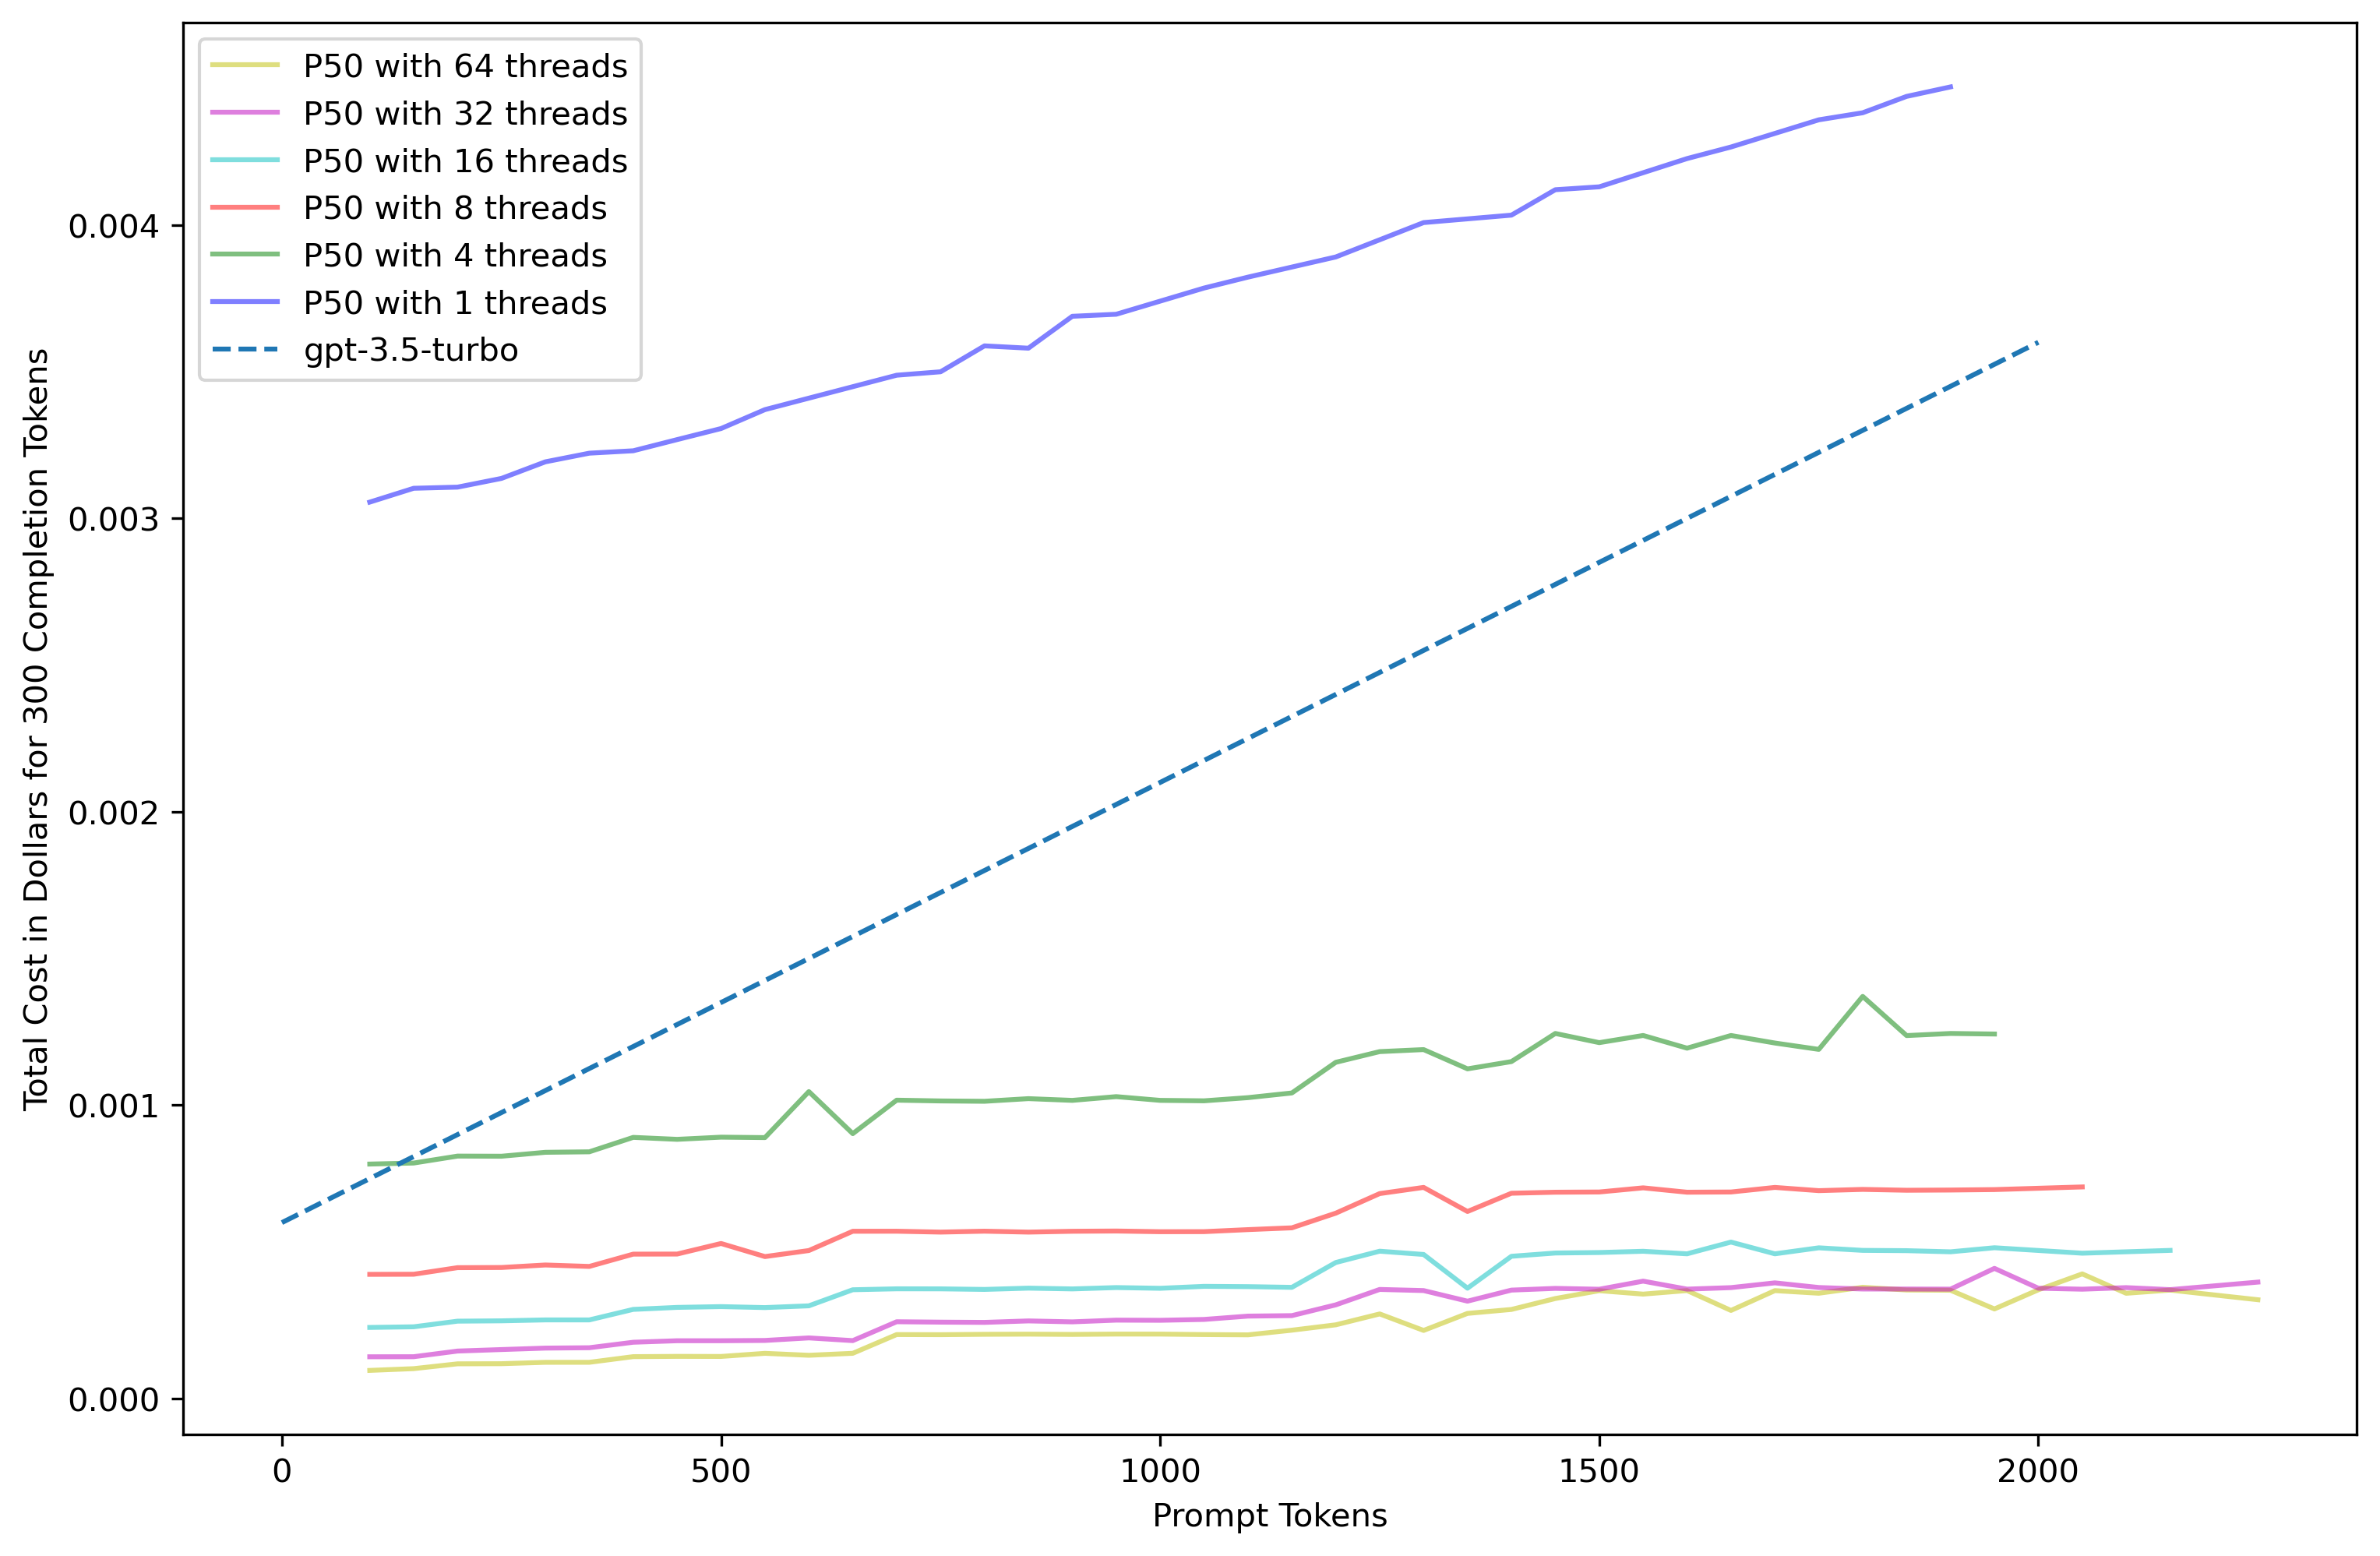

In [32]:
import numpy as np
from scipy.interpolate import make_interp_spline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import matplotlib

fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

key = "boot_time"

colors = ["b", "g", "r", "c", "m", "y"][::-1]

step_size = 50

for i, (k, v) in enumerate(list(parallel_d.items())[::-1]):
    if True or k != "64":
        x, y, c = list(
            zip(
                *[
                    (
                        d["prompt_tokens"],
                        1.69
                        / (
                            int(k)
                            * 3600
                            * 1000
                            / (
                                (
                                    d["profile_avg"]["model.tgi.profile"]
                                    + d["profile_avg"]["boot_time"]
                                )
                            )
                        ),
                        d["completion_tokens"],
                    )
                    for d in v
                ]
            )
        )
        # sx, sy, _ = list(zip(*sorted([(x[i], y[i], i) for i in range(len(x))], key=lambda x: x[0])))
        sx, sy = list(map(np.array, [x, y]))
        _, sind = np.unique(sx, return_index=True)
        xnew = np.linspace(sx.min(), sx.max(), 1000)
        
        _x = []
        _y = []
        for _c in range(100, sx.max(), step_size):
            _ind = np.logical_and(sx < _c, sx >= (_c - step_size))
            if sy[_ind].shape[0] > 0:
                _x.append(_c)
                _y.append([np.percentile(sy[_ind], p) for p in [25, 50, 75]])

        xnew = np.linspace(min(_x), max(_x), 1000)
        spl = make_interp_spline(_x, [__y[1] for __y in _y], k=2)  # type: BSpline
        y_smooth = spl(xnew)

        for n in [300, 1500]:
            print(f"cost @ {n} with {k}: { 100 * spl([n])}")

        _x = []
        _y = []
        for _c in range(100, sx.max(), step_size):
            _ind = np.logical_and(sx < _c, sx >= (_c - step_size))
            if sy[_ind].shape[0] > 0:
                _x.append(_c)
                _y.append([np.percentile(sy[_ind], p) for p in [5, 25, 50, 75, 95]])

        # ax.fill_between(_x, [__y[0] for __y in _y], [__y[4] for __y in _y],
        #                 color=colors[i], label=f'number of threads: {k}', alpha=0.3)
        # for l, (l1, l2) in enumerate([(0, 4), (1, 3)]):
        #     ax.fill_between(_x, [__y[l1] for __y in _y], [__y[l2] for __y in _y],
        #                     color=colors[i], alpha=0.05 * (l+1))
        ax.plot(
            _x,
            [__y[2] for __y in _y],
            color=colors[i],
            label=f"P50 with {k} threads",
            alpha=0.5,
        )

xnew = np.linspace(0, 2000, 1000)
print()
y = xnew * 0.0015 / 1000 + 0.002 * 300 / 1000
ax.plot(xnew, y, linestyle="dashed", label="gpt-3.5-turbo")
ax.set_yticks([0, 0.001, 0.002, 0.003, 0.004])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_tick_params(which="minor", size=0)
ax.get_yaxis().set_tick_params(which="minor", width=0)
ax.set_ylabel("Total Cost in Dollars for 300 Completion Tokens")
ax.set_xlabel("Prompt Tokens")
ax.legend()
fig.show()
fig.savefig("total-cost.png")